London Underground Network

In [205]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [206]:
Data = pd.read_csv('London_flows.csv')
G = nx.read_graphml('london.graph')
Data.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [207]:
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])  

In [208]:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

Degree Centrality

In [209]:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

In [210]:
df = pd.DataFrame(index=G.nodes())
df['station'] = df.index
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

df_D = df.sort_values(["degree"], ascending=False).reset_index(drop=True)
df_D[0:10]

,station,degree
0,Stratford,0.0225
1,Bank and Monument,0.0200
2,King's Cross St. Pancras,0.0175
3,Baker Street,0.0175
4,Earl's Court,0.0150
5,Oxford Circus,0.0150
6,Liverpool Street,0.0150
7,Waterloo,0.0150
8,Green Park,0.0150
9,Canning Town,0.0150


Topological betweenness centrality

In [211]:
### Topological betweenness centrality:

bet_london_t=nx.betweenness_centrality(G, normalized=True)
nx.set_node_attributes(G,bet_london_t,'betweenness_t')

df = pd.DataFrame(index=G.nodes())
df['station'] = df.index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

df_tb = df.sort_values(["betweenness_t"], ascending=False).reset_index(drop=True)
df_tb[0:10]

,station,betweenness_t
0,Stratford,0.297846
1,Bank and Monument,0.290489
2,Liverpool Street,0.270807
3,King's Cross St. Pancras,0.255307
4,Waterloo,0.243921
5,Green Park,0.215835
6,Euston,0.208324
7,Westminster,0.203335
8,Baker Street,0.191568
9,Finchley Road,0.165085


Topological Closeness Centrality

In [212]:
#topological closeness centrality
clos_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station'] = df.index
df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

df_tc = df.sort_values(["closeness_t"], ascending=False).reset_index(drop=True)
df_tc[0:10]

,station,closeness_t
0,Green Park,0.114778
1,Bank and Monument,0.113572
2,King's Cross St. Pancras,0.113443
3,Westminster,0.112549
4,Waterloo,0.112265
5,Oxford Circus,0.111204
6,Bond Street,0.110988
7,Farringdon,0.110742
8,Angel,0.110742
9,Moorgate,0.110314


Summary

In [213]:
Sum = pd.concat([df_D.station,df_tb.station,df_tc.station],axis=1)
Sum.columns.values[0] = 'Degree Centrality'
Sum.columns.values[1] = 'Topological Betweenness Centrality'
Sum.columns.values[2] = 'Topological Closeness Centrality'
Sum.head(10)

,Degree Centrality,Topological Betweenness Centrality,Topological Closeness Centrality
0,Stratford,Stratford,Green Park
1,Bank and Monument,Bank and Monument,Bank and Monument
2,King's Cross St. Pancras,Liverpool Street,King's Cross St. Pancras
3,Baker Street,King's Cross St. Pancras,Westminster
4,Earl's Court,Waterloo,Waterloo
5,Oxford Circus,Green Park,Oxford Circus
6,Liverpool Street,Euston,Bond Street
7,Waterloo,Westminster,Farringdon
8,Green Park,Baker Street,Angel
9,Canning Town,Finchley Road,Moorgate


Measure of removal

1. efficiency

In [214]:
nx.global_efficiency(G)

0.1012561935972123

2. diameter

In [215]:
# diameter of the network considering the distance between stations (weighted diameter)

nlen = {n:nx.single_source_dijkstra_path_length(G, n, weight='length') for n in G.nodes() }
e = nx.eccentricity(G,sp=nlen)
d = nx.diameter(G, e)
d

78581.28589029584

Node Removal

1. Stratgegry 1

In [216]:
# Assuming 'G' is your original graph and 'sum' is a DataFrame containing the top nodes based on centrality measures
re1 = pd.DataFrame(columns=['Removed Node', 'Global_Efficiency', 'Average_Shortest_Path', 'Centrality_Measure'])

# Copying G into three graphs for different centrality measures
G_1 = G.copy()
G_2 = G.copy()
G_3 = G.copy()

# Removing nodes and calculating metrics
for i in range(10):  # Only removing the top 10 nodes
    # For each centrality measure, remove nodes
    for G_i, R, centrality_measure in zip([G_1, G_2, G_3],
                                          [Sum['Degree Centrality'][i],
                                           Sum['Topological Betweenness Centrality'][i],
                                           Sum['Topological Closeness Centrality'][i]],
                                          ['Degree', 'Betweenness', 'Closeness']):
        
        if G_i.has_node(R):
            G_i.remove_node(R)
            e = nx.global_efficiency(G_i)  # Global efficiency calculation

            # Calculate average shortest path length for all connected components
            if nx.is_connected(G_i):
                a = nx.average_shortest_path_length(G_i)  # Average shortest path length calculation
            else:
                # Calculate the weighted average of average shortest path lengths across all connected components
                components = list(nx.connected_components(G_i))
                avg_path_lengths = [nx.average_shortest_path_length(G_i.subgraph(c)) for c in components]
                sizes = [len(c) for c in components]
                total_size = sum(sizes)
                weighted_avg_path_length = sum([len_ * path_len for len_, path_len in zip(sizes, avg_path_lengths)]) / total_size
                a = weighted_avg_path_length

            # Append the removed node and calculated metrics to the DataFrame
            re1 = re1._append({'Removed Node': R,
                              'Global_Efficiency': e,
                              'Average_Shortest_Path': a,
                              'Centrality_Measure': centrality_measure},
                             ignore_index=True)

# Display the results
print(re1)


C:\Users\gg208\AppData\Local\Temp\ipykernel_57532\1119556423.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  re1 = re1._append({'Removed Node': R,


                Removed Node  Global_Efficiency  Average_Shortest_Path  \
0                  Stratford           0.088917              13.976436   
1                  Stratford           0.088917              13.976436   
2                 Green Park           0.099190              13.824536   
3          Bank and Monument           0.085862              14.331390   
4          Bank and Monument           0.085862              14.331390   
5          Bank and Monument           0.094872              14.382728   
6   King's Cross St. Pancras           0.080287              15.450072   
7           Liverpool Street           0.084963              14.480369   
8   King's Cross St. Pancras           0.087934              15.983773   
9               Baker Street           0.075700              16.275627   
10  King's Cross St. Pancras           0.078498              15.248933   
11               Westminster           0.087372              16.080248   
12              Earl's Court          

In [217]:
initial_data = {
    'Removed Node': 'Origin',  
    'Centrality Value': 'N/A', 
    'Global_Efficiency': nx.global_efficiency(G),
    'Average_Shortest_Path': nx.average_shortest_path_length(G)
}


In [218]:
D_1 = re1[re1.Centrality_Measure =='Degree' ].reset_index(drop=True).drop(columns={'Centrality_Measure'})
D = D_1
D.loc[-1] = initial_data   
D = D.sort_index().reset_index(drop=True)
D

,Removed Node,Global_Efficiency,Average_Shortest_Path
0,Origin,0.101256,13.545998
1,Stratford,0.088917,13.976436
2,Bank and Monument,0.085862,14.331390
3,King's Cross St. Pancras,0.080287,15.450072
4,Baker Street,0.075700,16.275627
5,Earl's Court,0.074036,16.615229
6,Oxford Circus,0.072745,16.739554
7,Liverpool Street,0.070948,16.544913
8,Waterloo,0.068982,17.119374
9,Green Park,0.068257,17.245704


In [219]:
C_1 = re1[re1.Centrality_Measure =='Closeness' ].reset_index(drop=True).drop(columns={'Centrality_Measure'})
C = C_1
C.loc[-1] = initial_data  
C = C.sort_index().reset_index(drop=True)
C

,Removed Node,Global_Efficiency,Average_Shortest_Path
0,Origin,0.101256,13.545998
1,Green Park,0.099190,13.824536
2,Bank and Monument,0.094872,14.382728
3,King's Cross St. Pancras,0.087934,15.983773
4,Westminster,0.087372,16.080248
5,Waterloo,0.084859,16.855722
6,Oxford Circus,0.082781,17.431832
7,Bond Street,0.082581,17.464267
8,Farringdon,0.082600,17.462494
9,Angel,0.082622,17.460528


In [220]:
B_1 = re1[re1.Centrality_Measure =='Betweenness' ].reset_index(drop=True).drop(columns={'Centrality_Measure'})
B = B_1
B.loc[-1] = initial_data  
B = B.sort_index().reset_index(drop=True)
B

,Removed Node,Global_Efficiency,Average_Shortest_Path
0,Origin,0.101256,13.545998
1,Stratford,0.088917,13.976436
2,Bank and Monument,0.085862,14.331390
3,Liverpool Street,0.084963,14.480369
4,King's Cross St. Pancras,0.078498,15.248933
5,Waterloo,0.075942,15.925292
6,Green Park,0.074152,16.319393
7,Euston,0.068206,15.418565
8,Westminster,0.067660,15.562237
9,Baker Street,0.064700,16.010438


2. Stratgegry 2

In [221]:
def sequential_removal(G, centrality_func, num_nodes=10):
    local_G = G.copy()
    results = pd.DataFrame(columns=['Removed Node', 'Centrality Value', 'Global_Efficiency', 
                                    'Average_Shortest_Path'])
   
    for _ in range(num_nodes):
        # Recompute centrality every time after a node is removed
        centrality = centrality_func(local_G)
        # Find the node with the highest centrality
        highest_ranked_node = max(centrality, key=centrality.get)
        
        # Remove the node
        local_G.remove_node(highest_ranked_node)

        # Calculate global efficiency
        global_eff = nx.global_efficiency(local_G)
        
        # Calculate average path length
        if nx.is_connected(local_G):
            avg_path_len = nx.average_shortest_path_length(local_G)
        else:
            # Calculate the weighted average of average shortest path lengths across all connected components
            components = list(nx.connected_components(local_G))
            if components:  # Ensure there are components to process
                avg_path_lengths = [nx.average_shortest_path_length(local_G.subgraph(c)) for c in components]
                sizes = [len(c) for c in components]
                total_size = sum(sizes)
                weighted_avg_path_length = sum(len_ * path_len for len_, path_len in zip(sizes, avg_path_lengths)) / total_size
                avg_path_len = weighted_avg_path_length
            else:
                avg_path_len = float('inf')  # Handle the case where no components are available (unlikely)

        # Append the results for this iteration
        results = results._append({
            'Removed Node': highest_ranked_node,
            'Centrality Value': centrality[highest_ranked_node],
            'Global_Efficiency': global_eff,
            'Average_Shortest_Path': avg_path_len
        }, ignore_index=True)
        
    return results



In [222]:
degree_centrality = lambda G: nx.degree_centrality(G)
D2 = sequential_removal(G, degree_centrality, 10)
D_2 = D2
D_2.loc[-1] = initial_data  
D_2 = D_2.sort_index().reset_index(drop=True)
D_2

C:\Users\gg208\AppData\Local\Temp\ipykernel_57532\2432901029.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append({


,Removed Node,Centrality Value,Global_Efficiency,Average_Shortest_Path
0,Origin,N/A,0.101256,13.545998
1,Stratford,0.0225,0.088917,13.976436
2,Bank and Monument,0.02005,0.085862,14.331390
3,Baker Street,0.017588,0.082033,15.101026
4,King's Cross St. Pancras,0.017632,0.075700,16.275627
5,Canning Town,0.015152,0.070396,16.130829
6,Green Park,0.01519,0.069402,16.268572
7,Earl's Court,0.015228,0.067772,16.595774
8,Waterloo,0.012723,0.065936,17.136389
9,Oxford Circus,0.012755,0.065069,17.159526


In [223]:
betweenness_centrality = lambda G: nx.betweenness_centrality(G)
B2 = sequential_removal(G, betweenness_centrality, 10)
B_2 = B2
B_2.loc[-1] = initial_data  
B_2 = B_2.sort_index().reset_index(drop=True)
B_2

C:\Users\gg208\AppData\Local\Temp\ipykernel_57532\2432901029.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append({


,Removed Node,Centrality Value,Global_Efficiency,Average_Shortest_Path
0,Origin,N/A,0.101256,13.545998
1,Stratford,0.297846,0.088917,13.976436
2,King's Cross St. Pancras,0.247262,0.084603,14.745995
3,Waterloo,0.25418,0.081829,15.204749
4,Bank and Monument,0.214651,0.077678,16.144389
5,Canada Water,0.244903,0.072832,18.263595
6,West Hampstead,0.456831,0.053210,12.806572
7,Earl's Court,0.096182,0.051656,13.231721
8,Shepherd's Bush,0.128852,0.045844,12.607113
9,Euston,0.087075,0.041631,12.233886


In [224]:
closeness_centrality = lambda G: nx.closeness_centrality(G)
C2 = sequential_removal(G, closeness_centrality, 10)
C_2 = C2
C_2.loc[-1] = initial_data  
C_2 = C_2.sort_index().reset_index(drop=True)
C_2

C:\Users\gg208\AppData\Local\Temp\ipykernel_57532\2432901029.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append({


,Removed Node,Centrality Value,Global_Efficiency,Average_Shortest_Path
0,Origin,N/A,0.101256,13.545998
1,Green Park,0.114778,0.099190,13.824536
2,King's Cross St. Pancras,0.112363,0.094435,14.658480
3,Waterloo,0.104654,0.091816,15.114818
4,Bank and Monument,0.097423,0.085426,16.702427
5,West Hampstead,0.081734,0.080544,18.974696
6,Canada Water,0.075976,0.058101,12.692303
7,Stratford,0.063732,0.051884,13.100689
8,Earl's Court,0.063645,0.050350,13.528824
9,Shepherd's Bush,0.060434,0.044395,13.079434


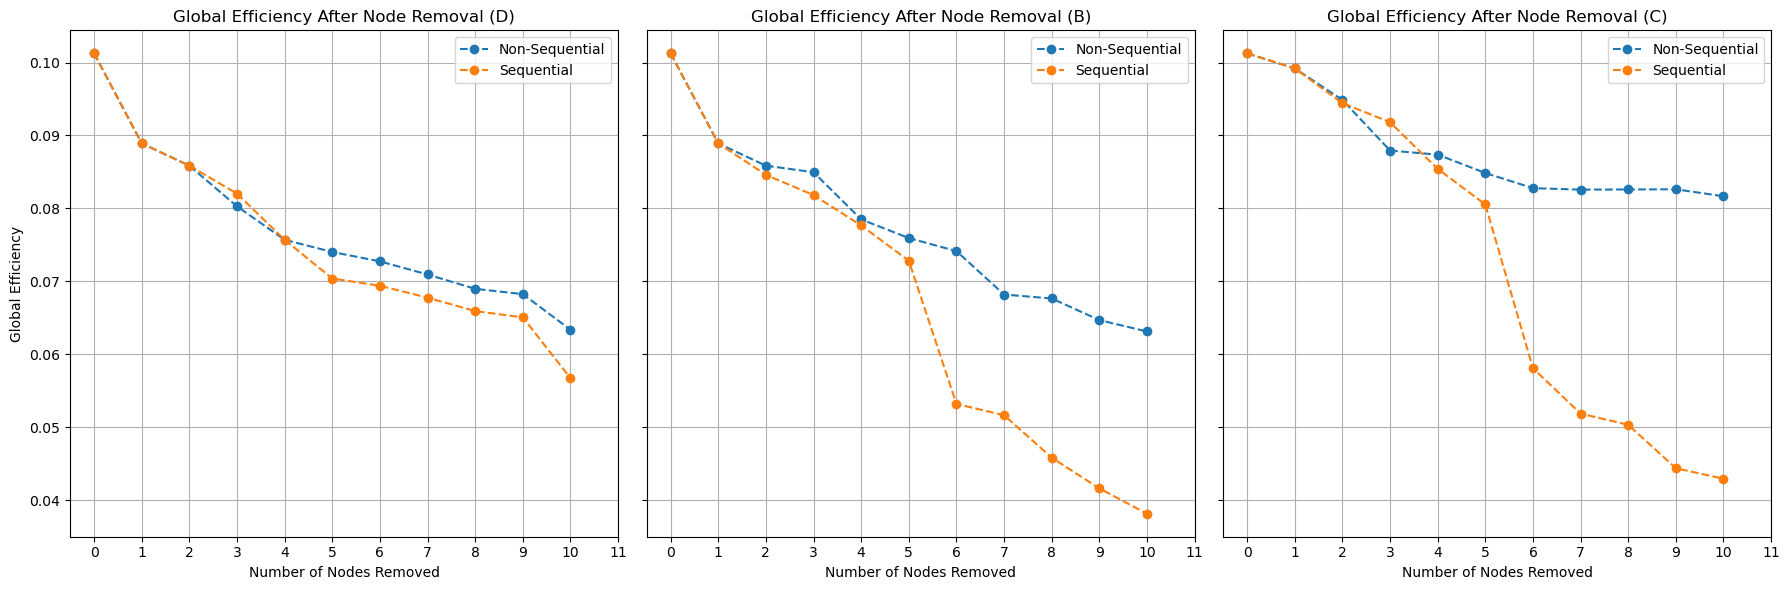

In [225]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Datasets to plot
data_sets = [ (D, D_2, 'D'), (B, B_2, 'B'),(C, C_2, 'C')]

# Plot data
for ax, (df1, df2, label) in zip(axes, data_sets):
    ax.plot(df1['Global_Efficiency'], label='Non-Sequential', marker='o', linestyle='--')
    ax.plot(df2['Global_Efficiency'], label='Sequential', marker='o', linestyle='--')
    ax.set_title(f'Global Efficiency After Node Removal ({label})')
    ax.set_xlabel('Number of Nodes Removed')
    ax.set_xticks(range(12))
    ax.legend()
    ax.grid(True)

# Set common labels
axes[0].set_ylabel('Global Efficiency')
plt.tight_layout()
plt.show()

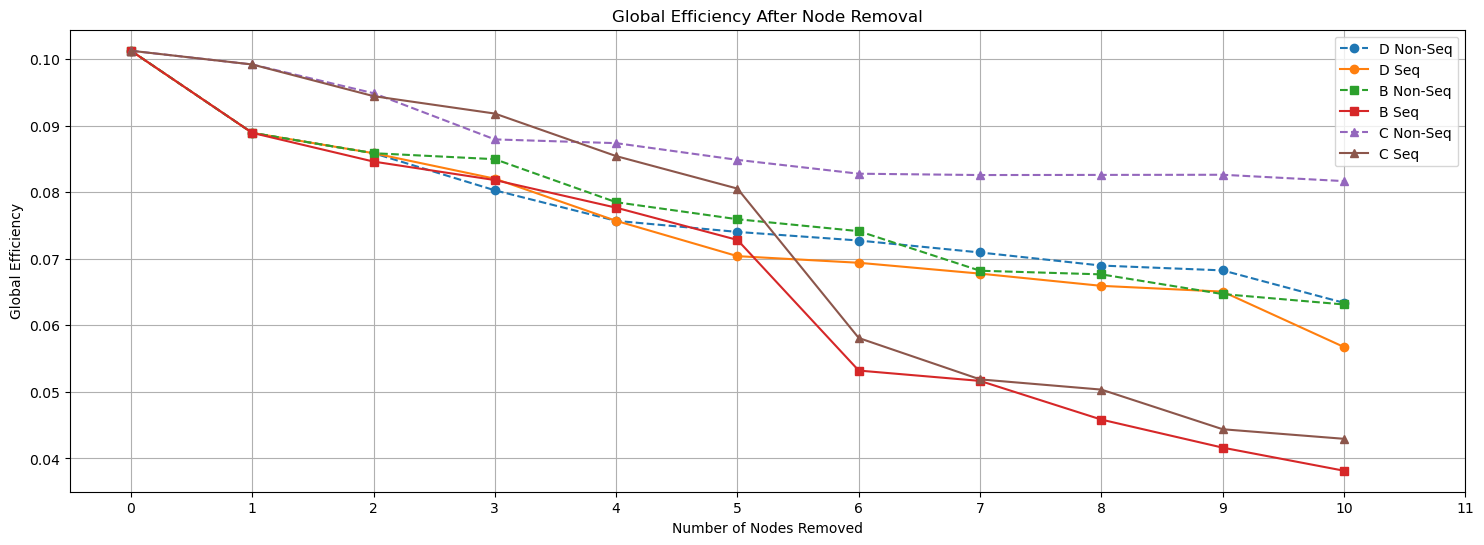

In [226]:
fig, ax = plt.subplots(figsize=(18, 6))

# Plot each dataset
ax.plot(D['Global_Efficiency'], label='D Non-Seq', marker='o', linestyle='--')
ax.plot(D_2['Global_Efficiency'], label='D Seq', marker='o')
ax.plot(B['Global_Efficiency'], label='B Non-Seq', marker='s', linestyle='--')
ax.plot(B_2['Global_Efficiency'], label='B Seq', marker='s')
ax.plot(C['Global_Efficiency'], label='C Non-Seq', marker='^', linestyle='--')
ax.plot(C_2['Global_Efficiency'], label='C Seq', marker='^')

# Customize the plot
ax.set_title('Global Efficiency After Node Removal')
ax.set_xlabel('Number of Nodes Removed')
ax.set_ylabel('Global Efficiency')
ax.set_xticks(range(12))
ax.legend()
ax.grid(True)

# Show the combined plot
plt.show()

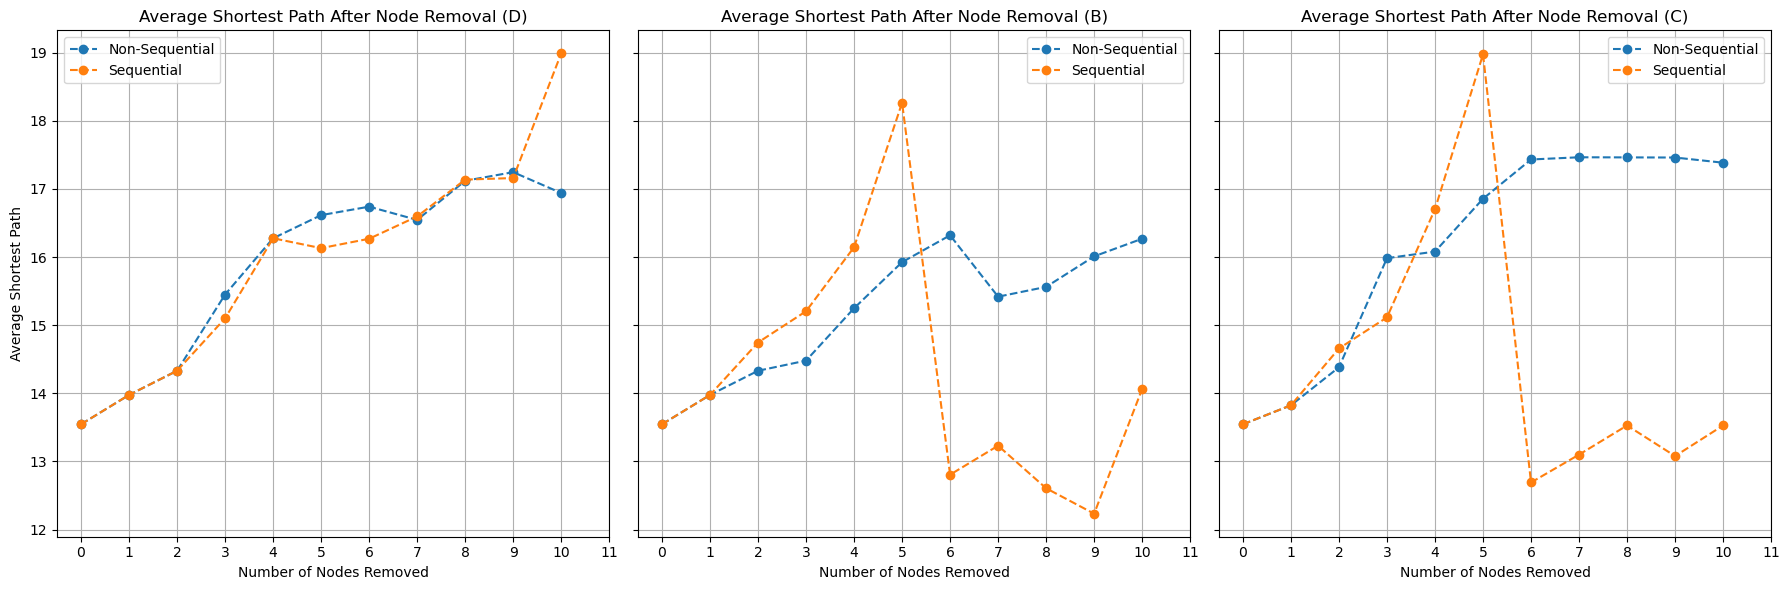

In [227]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

data_sets = [ (D, D_2, 'D'), (B, B_2, 'B'),(C, C_2, 'C')]

# Plot data
for ax, (df1, df2, label) in zip(axes, data_sets):
    ax.plot(df1['Average_Shortest_Path'], label='Non-Sequential', marker='o', linestyle='--')
    ax.plot(df2['Average_Shortest_Path'], label='Sequential', marker='o', linestyle='--')
    ax.set_title(f'Average Shortest Path After Node Removal ({label})')
    ax.set_xlabel('Number of Nodes Removed')
    ax.set_xticks(range(12))
    ax.legend()
    ax.grid(True)

# Set common labels
axes[0].set_ylabel('Average Shortest Path')
plt.tight_layout()
plt.show()

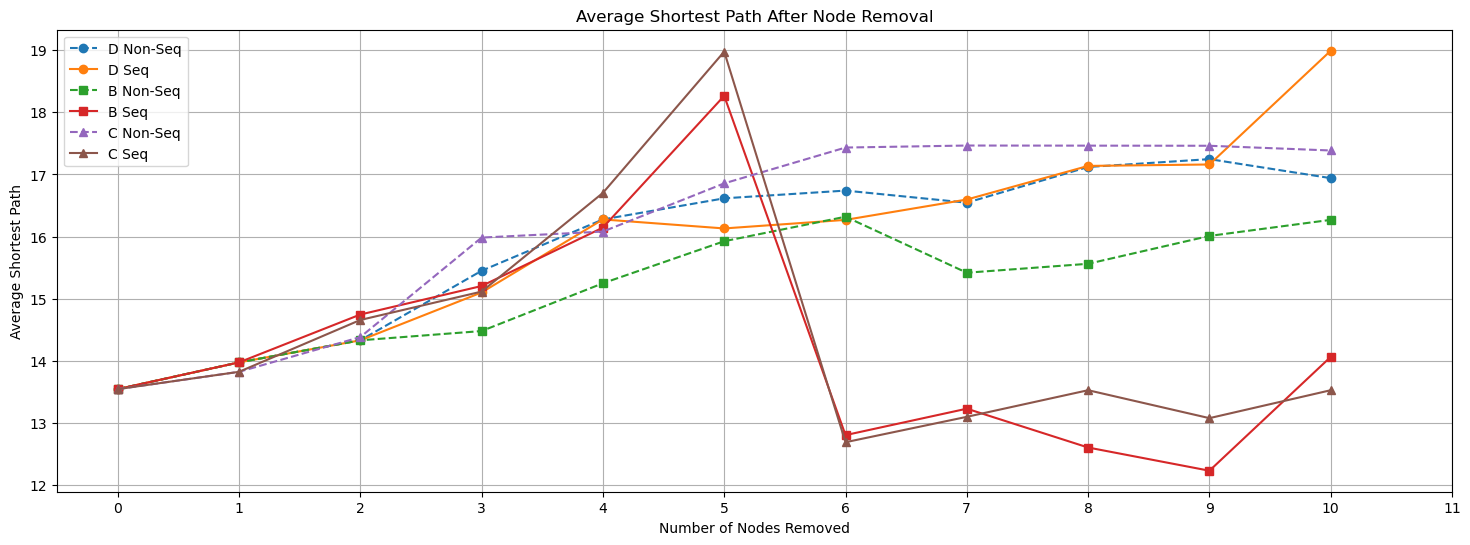

In [228]:
fig, ax = plt.subplots(figsize=(18, 6))

# Plot each dataset
ax.plot(D['Average_Shortest_Path'], label='D Non-Seq', marker='o', linestyle='--')
ax.plot(D_2['Average_Shortest_Path'], label='D Seq', marker='o')
ax.plot(B['Average_Shortest_Path'], label='B Non-Seq', marker='s', linestyle='--')
ax.plot(B_2['Average_Shortest_Path'], label='B Seq', marker='s')
ax.plot(C['Average_Shortest_Path'], label='C Non-Seq', marker='^', linestyle='--')
ax.plot(C_2['Average_Shortest_Path'], label='C Seq', marker='^')

# Customize the plot
ax.set_title('Average Shortest Path After Node Removal')
ax.set_xlabel('Number of Nodes Removed')
ax.set_ylabel('Average Shortest Path')
ax.set_xticks(range(12))
ax.legend()
ax.grid(True)

# Show the combined plot
plt.show()

Part II

Best centrality measure : Betweeness 
Better Strategry : strategry II
Better measurment : Global efficiency

In [229]:
list(G.edges(data = True))[4]

('Kingsbury',
 'Queensbury',
 {'length': 1245.9952343630068, 'line_name': 'Jubilee', 'flows': 9419})

In [230]:
Data.head(3)


,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872


In [231]:
# for index, row in Data.iterrows():
    #if G.has_edge(row['station_origin'], row['station_destination']):
        ##G[row['station_origin']][row['station_destination']]['flows'] = row['flows']


list(G.edges(data = True))[4]

('Kingsbury',
 'Queensbury',
 {'length': 1245.9952343630068, 'line_name': 'Jubilee', 'flows': 9419})

In [245]:
for u, v, d in G.edges(data=True):
    flow = d['flows']
    G[u][v]['inv_flows'] = 1.0 / flow if flow != 0 else 0

# 现在，计算加权介数中心性，使用'inv_flows'作为权重
bet_london_w = nx.betweenness_centrality(G, weight='inv_flows', normalized=True)

# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_w,'betweenness_w')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = df.index
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G, 'betweenness_w'))

df_sorted = df.sort_values(["betweenness_w"], ascending=False).reset_index(drop=True)
df_sorted[0:10]

,station_name,betweenness_w
0,Green Park,0.562563
1,Bank and Monument,0.498227
2,Waterloo,0.399803
3,Westminster,0.371736
4,Liverpool Street,0.332456
5,Stratford,0.327381
6,Bond Street,0.288177
7,Euston,0.279624
8,Oxford Circus,0.265752
9,Warren Street,0.249574


In [233]:
# Closeness just in case
clos_w=nx.closeness_centrality(G, distance='inv_flows')
nx.set_node_attributes(G,clos_w,'closeness_w')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = df.index
df['closeness_w'] = pd.Series(nx.get_node_attributes(G, 'closeness_w'))

df_sorted1 = df.sort_values(["closeness_w"], ascending=False)
df_sorted1[0:10]

,station_name,closeness_w
Green Park,Green Park,2377.569519
Westminster,Westminster,2372.542016
Waterloo,Waterloo,2367.998823
Bank and Monument,Bank and Monument,2364.577066
Oxford Circus,Oxford Circus,2355.796242
Bond Street,Bond Street,2352.780789
Victoria,Victoria,2345.842679
Liverpool Street,Liverpool Street,2345.155626
Warren Street,Warren Street,2329.989523
Moorgate,Moorgate,2325.095146


In [234]:
def W_GE(G,weight='inv_flows'):
    n = len(G)
    sum_of_efficiencies = 0.0
    
    for node in G:
        path_length = nx.single_source_dijkstra_path_length(G, node, weight=weight)

        for target in path_length:
            if node != target and path_length[target] != 0:
                sum_of_efficiencies += 1 / path_length[target]
    
    return sum_of_efficiencies / (n * (n - 1))

efficiency = W_GE(G)
print(f"The weighted global efficiency of the network is: {efficiency}")

The weighted global efficiency of the network is: 2724.447169356217


In [235]:
def W_ASPL(G, weight='inv_flows'):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight=weight))
    
    
    total_path_length = sum(sum(lengths.values()) for lengths in all_pairs_shortest_path_length.values())
    num_of_paths = sum(len(lengths) - 1 for lengths in all_pairs_shortest_path_length.values())
    
    
    return total_path_length / num_of_paths

avg_path_length = W_ASPL(G)
print(f"The weighted average shortest path length of the network is: {avg_path_length}")

The weighted average shortest path length of the network is: 0.000811491186039912


Strategry 1 

In [236]:
remove_list = df_sorted['station_name'][0:3]
remove_list

0           Green Park
1    Bank and Monument
2             Waterloo
Name: station_name, dtype: object

In [237]:
G_4 = G.copy()

W = pd.DataFrame(columns=['Remove_node','Weight_Efficiency','Weigth_SPL'])

W.loc[0] = ['original', W_GE(G_4), W_ASPL(G_4)]

for i, node in enumerate(remove_list, start=1):
    G_4.remove_node(node)
    WE = W_GE(G_4)
    WA = W_ASPL(G_4)

    W.loc[i] = [node, WE, WA]

W


,Remove_node,Weight_Efficiency,Weigth_SPL
0,original,2724.447169,0.000811
1,Green Park,2453.571403,0.000839
2,Bank and Monument,2108.971054,0.000890
3,Waterloo,2006.165230,0.000965


In [238]:
remove_list2 = Sum['Topological Betweenness Centrality'][0:3]
remove_list2

0            Stratford
1    Bank and Monument
2     Liverpool Street
Name: Topological Betweenness Centrality, dtype: object

In [239]:
G_4 = G.copy()

W1 = pd.DataFrame(columns=['Remove_node','Weight_Efficiency','Weigth_SPL'])

W1.loc[0] = ['original', W_GE(G_4), W_ASPL(G_4)]

for i, node in enumerate(remove_list2, start=1):
    G_4.remove_node(node)
    WE = W_GE(G_4)
    WA = W_ASPL(G_4)

    W1.loc[i] = [node, WE, WA]

W1


,Remove_node,Weight_Efficiency,Weigth_SPL
0,original,2724.447169,0.000811
1,Stratford,2286.014356,0.001115
2,Bank and Monument,2115.524018,0.001136
3,Liverpool Street,2062.332823,0.001161


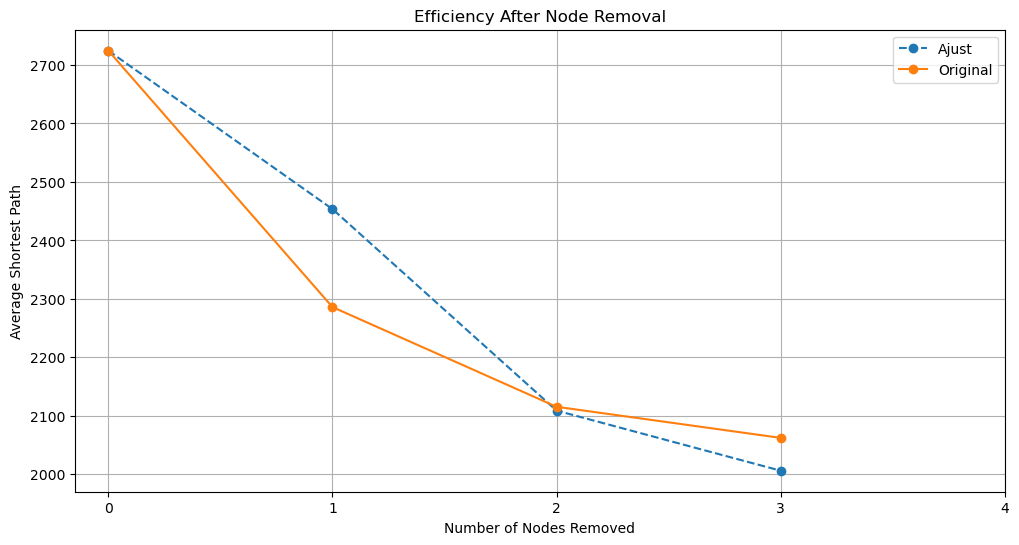

In [240]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each dataset
ax.plot(W['Weight_Efficiency'], label='Ajust', marker='o', linestyle='--')
ax.plot(W1['Weight_Efficiency'], label='Original', marker='o')


# Customize the plot
ax.set_title('Efficiency After Node Removal')
ax.set_xlabel('Number of Nodes Removed')
ax.set_ylabel('Average Shortest Path')
ax.set_xticks(range(5))
ax.legend()
ax.grid(True)

# Show the combined plot
plt.show()

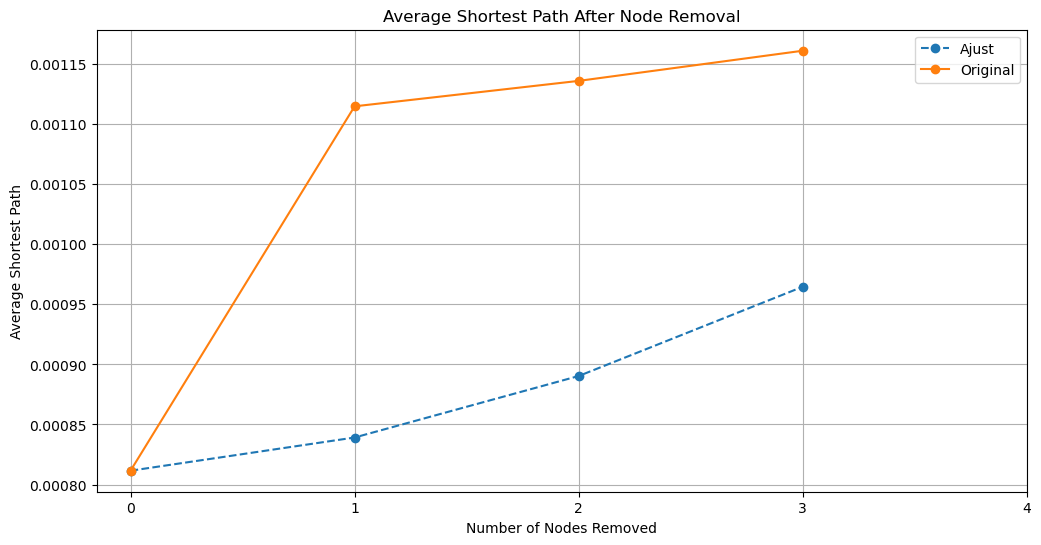

In [241]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each dataset
ax.plot(W['Weigth_SPL'], label='Ajust', marker='o', linestyle='--')
ax.plot(W1['Weigth_SPL'], label='Original', marker='o')


# Customize the plot
ax.set_title('Average Shortest Path After Node Removal')
ax.set_xlabel('Number of Nodes Removed')
ax.set_ylabel('Average Shortest Path')
ax.set_xticks(range(5))
ax.legend()
ax.grid(True)

# Show the combined plot
plt.show()

strategry 2

In [242]:
G_4 = G.copy()

W2 = pd.DataFrame(columns=['Remove_node','Weight_Efficiency','Weigth_SPL'])

W2.loc[0] = ['original', W_GE(G_4), W_ASPL(G_4)]

for i in range(3):
    centralities = nx.betweenness_centrality(G_4, weight='inv_flows', normalized=True)
    highest_node = max(centralities, key=centralities.get)
    G_4.remove_node(highest_node)
    WE = W_GE(G_4)
    WA = W_ASPL(G_4)

    W2.loc[i+1] = [highest_node, WE, WA]

print(W2)


                Remove_node  Weight_Efficiency  Weigth_SPL
0                  original        2724.447169    0.000811
1                Green Park        2453.571403    0.000839
2         Bank and Monument        2108.971054    0.000890
3  King's Cross St. Pancras        1744.504533    0.001049


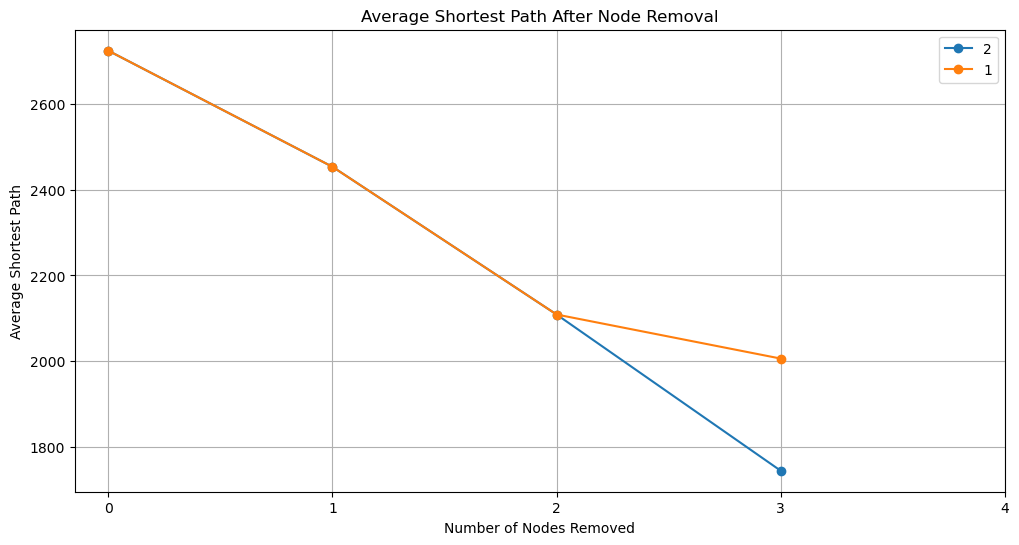

In [243]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each dataset
ax.plot(W2['Weight_Efficiency'], label='2', marker='o')
ax.plot(W['Weight_Efficiency'], label='1', marker='o')

# Customize the plot
ax.set_title('Average Shortest Path After Node Removal')
ax.set_xlabel('Number of Nodes Removed')
ax.set_ylabel('Average Shortest Path')
ax.set_xticks(range(5))
ax.legend()
ax.grid(True)

# Show the combined plot
plt.show()